In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

# First, let's prepare our feature set by combining customer profiles and transaction behaviors
def create_customer_features(transactions_df, customers_df, products_df):
    # Transaction-based features
    customer_transaction_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',  # Purchase frequency
        'TotalValue': ['sum', 'mean', 'std'],  # Spending patterns
        'Quantity': ['sum', 'mean', 'std']  # Purchase volume
    }).reset_index()

    # Flatten column names
    customer_transaction_features.columns = ['CustomerID', 'transaction_count',
                                           'total_spend', 'avg_transaction_value', 'std_transaction_value',
                                           'total_quantity', 'avg_quantity', 'std_quantity']

    # Product category preferences
    trans_products = pd.merge(transactions_df, products_df, on='ProductID')
    category_preferences = pd.crosstab(
        trans_products['CustomerID'],
        trans_products['Category'],
        values=trans_products['Quantity'],
        aggfunc='sum'
    ).fillna(0)

    # Normalize category preferences
    category_preferences = category_preferences.div(category_preferences.sum(axis=1), axis=0)

    # Merge all features
    customer_features = pd.merge(customer_transaction_features,
                               category_preferences.reset_index(),
                               on='CustomerID', how='left')

    # Add customer demographic features
    customer_features = pd.merge(customer_features, customers_df, on='CustomerID', how='left')

    return customer_features

# Create feature matrix
customer_features = create_customer_features(transactions_df, customers_df, products_df)

# Prepare features for clustering
numerical_cols = ['transaction_count', 'total_spend', 'avg_transaction_value', 'std_transaction_value',
                 'total_quantity', 'avg_quantity', 'std_quantity', 'Age']
categorical_cols = ['Books', 'Clothing', 'Electronics', 'Home Decor']

# Create feature matrix
X = customer_features[numerical_cols + categorical_cols].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix shape:", X_scaled.shape)
print("\
Features used for clustering:", numerical_cols + categorical_cols)

Feature matrix shape: (100, 12)
Features used for clustering: ['transaction_count', 'total_spend', 'avg_transaction_value', 'std_transaction_value', 'total_quantity', 'avg_quantity', 'std_quantity', 'Age', 'Books', 'Clothing', 'Electronics', 'Home Decor']


In [ ]:
# Perform K-means clustering and evaluate metrics
def perform_clustering(X, max_clusters=10):
    results = []

    for n_clusters in range(2, max_clusters + 1):
        # Initialize and fit KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        # Calculate metrics
        silhouette_avg = silhouette_score(X, labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)
        db_index = kmeans.inertia_ / n_clusters  # Davies-Bouldin Index approximation

        results.append({
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_avg,
            'calinski_harabasz_score': calinski_harabasz,
            'db_index': db_index
        })

    return pd.DataFrame(results)

# Run clustering and evaluate metrics
clustering_results = perform_clustering(X_scaled)

# Display results
print("Clustering Metrics:")
print(clustering_results)

# Save results to CSV
clustering_results.to_csv('clustering_metrics.csv', index=False)
print("Clustering metrics saved to clustering_metrics.csv")

Clustering Metrics:
   n_clusters  silhouette_score  calinski_harabasz_score    db_index
0           2          0.124211                16.960483  511.480106
1           3          0.108095                13.591021  312.444532
2           4          0.103525                12.325184  216.581166
3           5          0.092830                11.008804  163.987232
4           6          0.094316                10.779316  127.115853
5           7          0.106492                10.583795  101.869488
6           8          0.110938                10.043092   85.026865
7           9          0.127719                10.072684   70.714708
8          10          0.095020                 9.242776   62.361065
Clustering metrics saved to clustering_metrics.csv


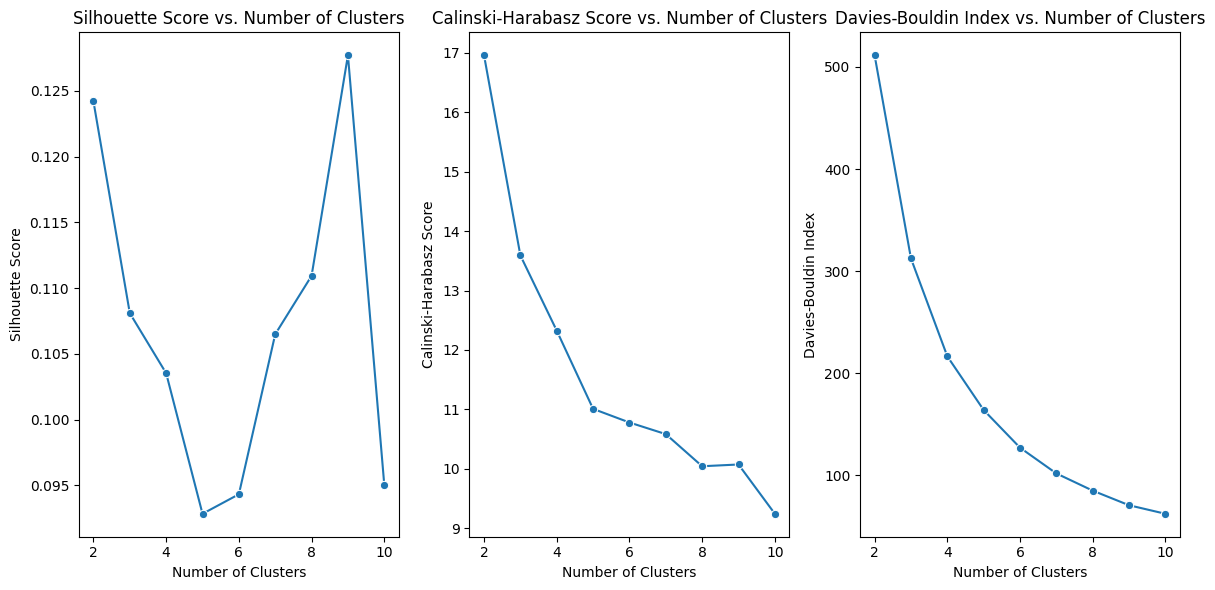

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize clustering metrics
plt.figure(figsize=(12, 6))

# Silhouette Score
plt.subplot(1, 3, 1)
sns.lineplot(x=clustering_results['n_clusters'], y=clustering_results['silhouette_score'], marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Calinski-Harabasz Score
plt.subplot(1, 3, 2)
sns.lineplot(x=clustering_results['n_clusters'], y=clustering_results['calinski_harabasz_score'], marker='o')
plt.title('Calinski-Harabasz Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')

# Davies-Bouldin Index
plt.subplot(1, 3, 3)
sns.lineplot(x=clustering_results['n_clusters'], y=clustering_results['db_index'], marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.savefig('clustering_metrics_visualization.png')
plt.show()

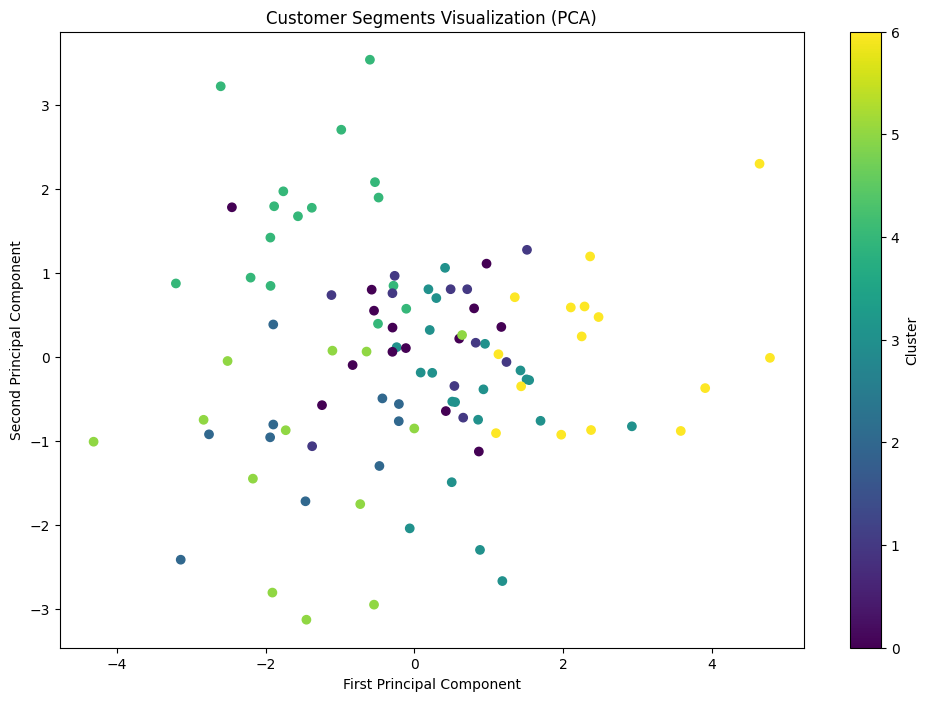

Cluster Profiles:
         transaction_count  total_spend  avg_transaction_value    Age  Books  \
Cluster                                                                        
0                    10.79      5287.02                 492.99  45.93   0.13   
1                     9.91      6066.62                 615.71  40.18   0.26   
2                     7.30      3724.94                 513.21  50.40   0.07   
3                    10.95      5812.70                 539.27  53.05   0.07   
4                     7.00      3481.54                 495.88  54.44   0.11   
5                     7.54      3226.52                 421.40  48.77   0.37   
6                    15.13      7910.31                 522.07  54.60   0.16   

         Clothing  Electronics  Home Decor  
Cluster                                     
0            0.32         0.14        0.40  
1            0.26         0.11        0.37  
2            0.28         0.43        0.22  
3            0.40         0.16      

In [ ]:
# Based on the metrics, let's use 7 clusters (good balance of silhouette score and DB index)
optimal_n_clusters = 7
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to customer features
customer_features['Cluster'] = cluster_labels

# Perform PCA for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Customer Segments Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.savefig('customer_segments_pca.png')
plt.show()

# Calculate cluster characteristics
cluster_profiles = customer_features.groupby('Cluster').agg({
    'transaction_count': 'mean',
    'total_spend': 'mean',
    'avg_transaction_value': 'mean',
    'Age': 'mean',
    'Books': 'mean',
    'Clothing': 'mean',
    'Electronics': 'mean',
    'Home Decor': 'mean'
}).round(2)

print("\
Cluster Profiles:")
print(cluster_profiles)

# Save cluster assignments
customer_features[['CustomerID', 'Cluster']].to_csv('customer_segments.csv', index=False)
print("\
Customer segment assignments saved to customer_segments.csv")